In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
)

In [ ]:
# 1. Generate synthetic data (binary classification, 70/30 imbalance)
def generate_data(n_samples=1000, seed=42):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=10,
        n_informative=6,
        n_redundant=2,
        n_classes=2,
        weights=[0.7, 0.3],
        flip_y=0.01,
        random_state=seed
    )
    df = pd.DataFrame(X, columns=[f"num_{i}" for i in range(X.shape[1])])
    df["cat_1"] = np.random.choice(["A", "B", "C"], size=n_samples)
    df["cat_2"] = np.random.choice(["X", "Y"], size=n_samples)
    df["target"] = y
    return df

df = generate_data()


In [ ]:
# 2. Train/Val/Test split
train_val, test = train_test_split(df, test_size=0.2, stratify=df["target"], random_state=42)
train, val = train_test_split(train_val, test_size=0.1, stratify=train_val["target"], random_state=42)

In [ ]:
# 3. Preprocessing (shared logic)
num_features = [col for col in df.columns if col.startswith("num_")]
cat_features = ["cat_1", "cat_2"]
features = num_features + cat_features
target = "target"

# Helper: create ColumnTransformer pipeline
def make_preprocessor():
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    return ColumnTransformer([
        ("num", numeric_pipeline, num_features),
        ("cat", categorical_pipeline, cat_features)
    ])

In [ ]:
# 4. Define base learners with their own pipelines
def make_base_pipeline(estimator):
    return Pipeline([
        ("preprocessor", make_preprocessor()),
        ("model", estimator)
    ])

base_learners = [
    ("lr", make_base_pipeline(LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))),
    ("rf", make_base_pipeline(RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42))),
    ("gb", make_base_pipeline(GradientBoostingClassifier(n_estimators=100, random_state=42)))
]

In [ ]:
# 5. Define stacking classifier
final_estimator = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)
stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

In [ ]:
# 6. Train ensemble
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

stacked_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['num_0',
                                                                                   'num_1',
                                                                                   'num_2',
                                                                                   'num_3',
                                                                                   'num_4',
                                                                                   'num_5',
                                                                                   'num_6',
                                                                                   'num_7',
                                                                                   'num_8',
                                                                                   'num_9']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='most_...
                                                                                   'num_8',
                                                                                   'num_9']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('onehot',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse_output=False))]),
                                                                                  ['cat_1',
                                                                                   'cat_2'])])),
                                                ('model',
                                                 GradientBoostingClassifier(random_state=42))]))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42,
                                                      solver='liblinear'),
                   n_jobs=-1)

In [ ]:
# 7. Evaluate
def evaluate_model(model, X, y, name="test"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    metrics = {
        "accuracy": accuracy_score(y, y_pred),
        "precision_macro": precision_score(y, y_pred, average="macro"),
        "recall_macro": recall_score(y, y_pred, average="macro"),
        "f1_macro": f1_score(y, y_pred, average="macro"),
        "roc_auc": roc_auc_score(y, y_proba),
        "pr_auc": average_precision_score(y, y_proba)
    }
    print(f"\n{name.upper()} METRICS")
    print(json.dumps(metrics, indent=2))

    os.makedirs("figures", exist_ok=True)


        # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"figures/{name}_confusion_matrix.png")
    plt.show()

# ROC curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.2f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig(f"figures/{name}_roc_curve.png")
    plt.show()

    # PR curve
    precision, recall, _ = precision_recall_curve(y, y_proba)
    plt.plot(recall, precision, label=f"AUC = {metrics['pr_auc']:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.savefig(f"figures/{name}_pr_curve.png")
    plt.show()

    return metrics




VAL METRICS
{
  "accuracy": 0.9125,
  "precision_macro": 0.8996948893974066,
  "recall_macro": 0.8898809523809523,
  "f1_macro": 0.8945584635661834,
  "roc_auc": 0.9754464285714286,
  "pr_auc": 0.950731158006308
}


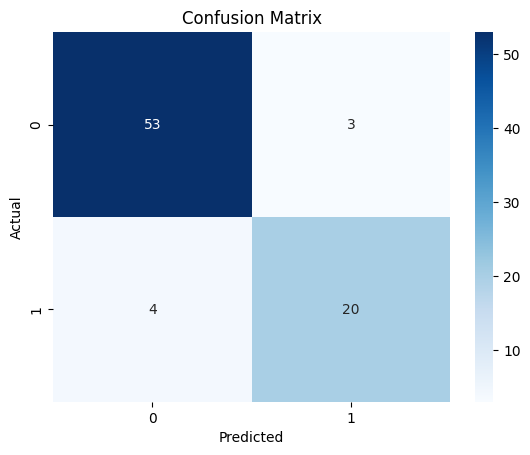

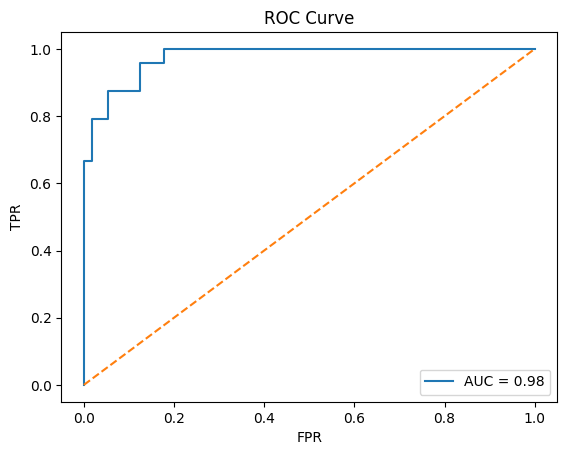

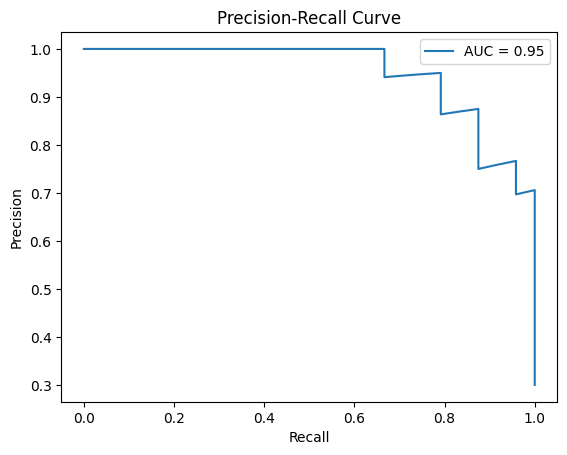


TEST METRICS
{
  "accuracy": 0.85,
  "precision_macro": 0.820731312695502,
  "recall_macro": 0.8506899398513976,
  "f1_macro": 0.8316687240489282,
  "roc_auc": 0.9589574242245548,
  "pr_auc": 0.922406446523578
}


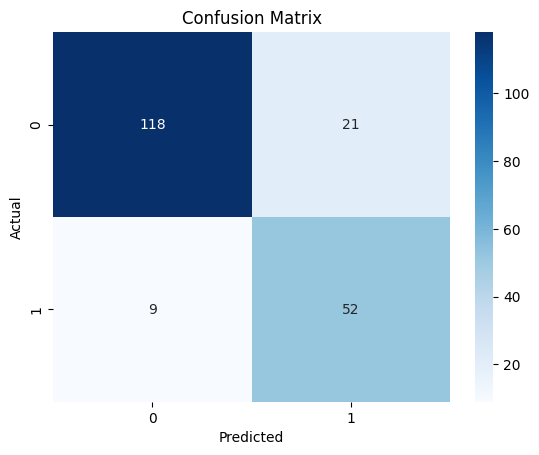

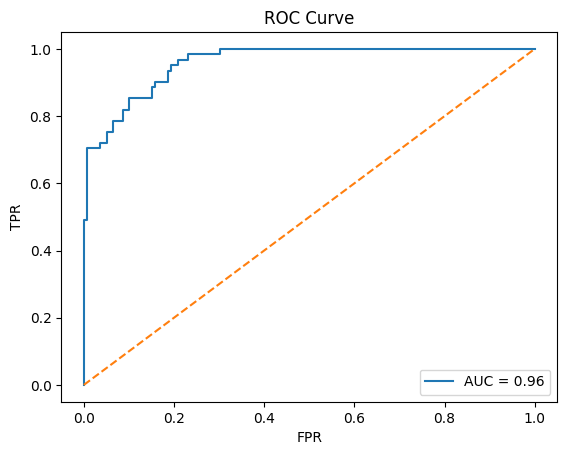

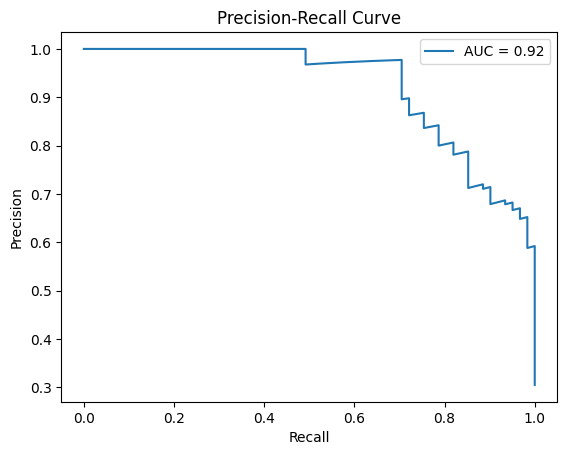

In [ ]:
# 8. Run evaluation
evaluate_model(stacked_clf, X_val, y_val, name="val")
metrics = evaluate_model(stacked_clf, X_test, y_test, name="test")

Core Methodological Themes in StackNet:

Stacked Generalization (Stacking)

Modular, base-specific preprocessing pipelines

Cross-validated meta-learning

Ensemble robustness and model diversity

🔬 Key Academic References
1. Foundational Paper on Stacking

Wolpert, D. H. (1992).
"Stacked Generalization"
Neural Networks, 5(2), 241–259.
📌 Relevance: Introduces the concept of meta-learners that aggregate base models’ outputs via cross-validation, improving generalization.
🔗 https://doi.org/10.1016/S0893-6080(05)80023-1

2. Ensemble Diversity and Model Robustness

Kuncheva, L. I., & Whitaker, C. J. (2003).
"Measures of Diversity in Classifier Ensembles and Their Relationship with the Ensemble Accuracy"
Machine Learning, 51, 181–207.
📌 Relevance: Shows how model diversity (e.g., combining LR, RF, GBDT) enhances ensemble accuracy and robustness.
🔗 https://doi.org/10.1023/A:1022859003006

3. Stacking and Base Learner Preprocessing

Ting, K. M., & Witten, I. H. (1997).
"Stacked Generalization: When Does It Work?"
IJCAI-97 Proceedings, 866–871.
📌 Relevance: Empirically studies the effectiveness of stacking when base learners are heterogeneous and trained with distinct preprocessing — validating StackNet’s modular pipelines.
🔗 IJCAI-97 Paper

4. Practical Use of Stacking in Modern ML

Pedregosa, F. et al. (2011).
"Scikit-learn: Machine Learning in Python"
JMLR, 12, 2825–2830.
📌 Relevance: Describes StackingClassifier and the role of pipelines in constructing modular ensemble models within scikit-learn.
🔗 https://jmlr.org/papers/v12/pedregosa11a.html

✅ Summary Statement

StackNet is directly grounded in the concept of stacked generalization proposed by Wolpert (1992), where a meta-learner combines predictions from diverse base learners (e.g., LR, RF, GBDT). Its use of base-specific preprocessing pipelines and cross-validated training aligns with best practices from Ting & Witten (1997) and Kuncheva & Whitaker (2003), emphasizing ensemble diversity and layered generalization for robust performance.